In [24]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 5
Total threads: 20,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42557,Workers: 5
Dashboard: /proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:36719,Total threads: 4
Dashboard: /proxy/34727/status,Memory: 25.04 GiB
Nanny: tcp://127.0.0.1:35421,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# salterature of meltwater at the freezing point calculated with the in situ salinity:
Tfreezing_insituS = 'accessom2-GPC004'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
Tfreezing_zeroS = 'accessom2-GPC005'
# temperature of meltwater equal to the minimum of the above two temperatures:
Tfreezing_min = 'accessom2-GPC006'

start_time='2150-01-01'
end_time='2152-01-01'

lat_slice  = slice(-80,-59)

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC004/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC005/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC006/',]
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC004
Indexing experiment: accessom2-GPC005
Indexing experiment: accessom2-GPC006


0it [00:00, ?it/s]


0

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [7]:
# First plot map of bottom temperature to see where we want to plot transects

In [12]:
start_time='2151-01-01'
end_time='2152-01-01'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_con = temp_con.mean('time')

temp_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min = temp_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_Tfreezing_min = temp_Tfreezing_min.mean('time')



In [13]:
# select out bottom values:
depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_Tfreezing_min = temp_Tfreezing_min.where(depth_array.st_ocean >= max_depth)
bottom_temp_Tfreezing_min = bottom_temp_Tfreezing_min.sum(dim = 'st_ocean')
bottom_temp_Tfreezing_min = bottom_temp_Tfreezing_min.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

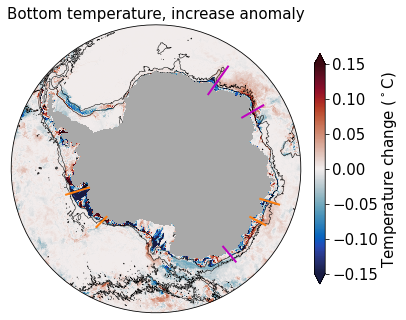

In [15]:
scale_max = 0.15

fig  = plt.figure(1, figsize = (10,8))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# up:
# setup stereo projection:
ax = fig.add_axes([0.0, 0.5, 0.5, 0.5],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_min-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Bottom temperature, increase anomaly',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())

# Add transect lines:
# AmundsenE:
plt.plot([-107,-107],[-75,-70],'C1',linewidth=2,transform = ccrs.PlateCarree())
# AmundsenW:
plt.plot([-135,-135],[-75,-72],'C1',linewidth=2,transform = ccrs.PlateCarree())
# warm patch just downstream of Mertz:
plt.plot([-220,-220],[-68,-64],'m',linewidth=2,transform = ccrs.PlateCarree())
# cooling in Totten:
plt.plot([-242,-242],[-67.5,-64],'C1',linewidth=2,transform = ccrs.PlateCarree())
# cold patch in Vincennes Bay:
plt.plot([-253,-253],[-67,-63],'C1',linewidth=2,transform = ccrs.PlateCarree())
# warm patch downstream of PrydzE:
plt.plot([60,60],[-69,-64],'m',linewidth=2,transform = ccrs.PlateCarree())
# warm patch downstream of PrydzW:
plt.plot([35.5,35.5],[-71,-64],'m',linewidth=2,transform = ccrs.PlateCarree())
        
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.47, 0.55, 0.015, 0.4])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

#figure_path = figdir+'map_bottom_temp_with_transect_locations.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

In [16]:
#Temperature transects

In [31]:
zlevel1 = 0
zlevel2 = 1600

first_year = '2151'
last_year = '2151'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

def get_transect_data(lon,lat1,lat2):
    lat_slice  = slice(lat1, lat2)

    # import bathymetry:
    ht_transect = cc.querying.getvar(control,'ht',master_session,n=1)
    ht_transect = ht_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice)
    ht_transect = ht_transect.load()
    ht_transect[np.isnan(ht_transect)] = 0

    ### load data for this period:
    temp_con_transect = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_con_transect = temp_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    temp_con_transect = temp_con_transect.load()

    temp_Tfreezing_min_transect = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_Tfreezing_min_transect = temp_Tfreezing_min_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    temp_Tfreezing_min_transect = temp_Tfreezing_min_transect.load()

    ### load data for this period:
    salt_con_transect = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_con_transect = salt_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    salt_con_transect = salt_con_transect.load()

    salt_Tfreezing_min_transect = cc.querying.getvar(Tfreezing_min, 'salt', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_Tfreezing_min_transect = salt_Tfreezing_min_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    salt_Tfreezing_min_transect = salt_Tfreezing_min_transect.load()

    ### also get density for plotting isopycnals:
    rho0_con = cc.querying.getvar(control,'pot_rho_0' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_con = rho0_con.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    rho0_con = rho0_con.load()

    rho0_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'pot_rho_0', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_Tfreezing_min = rho0_Tfreezing_min.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    rho0_Tfreezing_min = rho0_Tfreezing_min.load()
    
    return ht_transect,temp_con_transect,temp_Tfreezing_min_transect,salt_con_transect,salt_Tfreezing_min_transect,rho0_con,rho0_Tfreezing_min


In [32]:
def plot_transects(region):

    if region == 'AmundsenW':
        lon = -135
        lat1 = -74.7
        lat2 = -73
    elif region == 'AmundsenE':
        lon = -107
        lat1 = -75
        lat2 = -70
    elif region == 'Mertz':
        lon = -220
        lat1 = -66.8
        lat2 = -64.5
    elif region == 'Totten':
        lon = -242
        lat1 = -67.2
        lat2 = -64
    elif region == 'Vincennes':
        lon = -253
        lat1 = -67
        lat2 = -63
    elif region == 'PrydzE':
        lon = 60
        lat1 = -67.5
        lat2 = -64    
    elif region == 'PrydzW':
        lon = 35.5
        lat1 = -69.5
        lat2 = -66 

    ht_transect,temp_con_transect,temp_Tfreezing_min_transect,salt_con_transect,salt_Tfreezing_min_transect,rho0_con,rho0_Tfreezing_min = get_transect_data(lon,lat1,lat2+.1)

    fontsize=16

    fig=plt.figure(figsize=(20,16))

    scale_max = 0.4

    density_contours = [1027.5,1027.6,1027.72,1027.78,1027.81,1027.83,1027.835,1027.84,1027.845,1027.85]

    #### Control temp:
    plt.subplot(2,3,1)
    norm = col.Normalize(vmin=-2,vmax=1.5)
    levels=np.arange(-2,1.65,.05)
    ticks = [-2,-1,0,1]

    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### Tfreezing_min temp:
    plt.subplot(2,3,2)
    norm = col.Normalize(vmin=-.4,vmax=.4)
    levels=np.arange(-.4,.405,.005)
    ticks = [-.4,-.2,0,.2,.4]
    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_Tfreezing_min_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       temp_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_Tfreezing_min,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    plt.title(region+', longitude='+str(lon),fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Tfreezing_min Temperature anomaly ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #### Control salt:
    plt.subplot(2,3,4)
    norm = col.Normalize(vmin=33.7,vmax=34.8)
    levels=np.arange(33.7,34.81,.01)
    ticks = [33.8,34,34.2,34.4,34.6,34.8]

    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       salt_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Salinity ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### Tfreezing_min salt:
    plt.subplot(2,3,5)
    norm = col.Normalize(vmin=-.1,vmax=.1)
    levels=np.arange(-.1,.101,.001)
    ticks = [-.1,-.05,0,.05,.1]
    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       salt_Tfreezing_min_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       salt_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_Tfreezing_min,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Tfreezing_min Salinity anomaly',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)

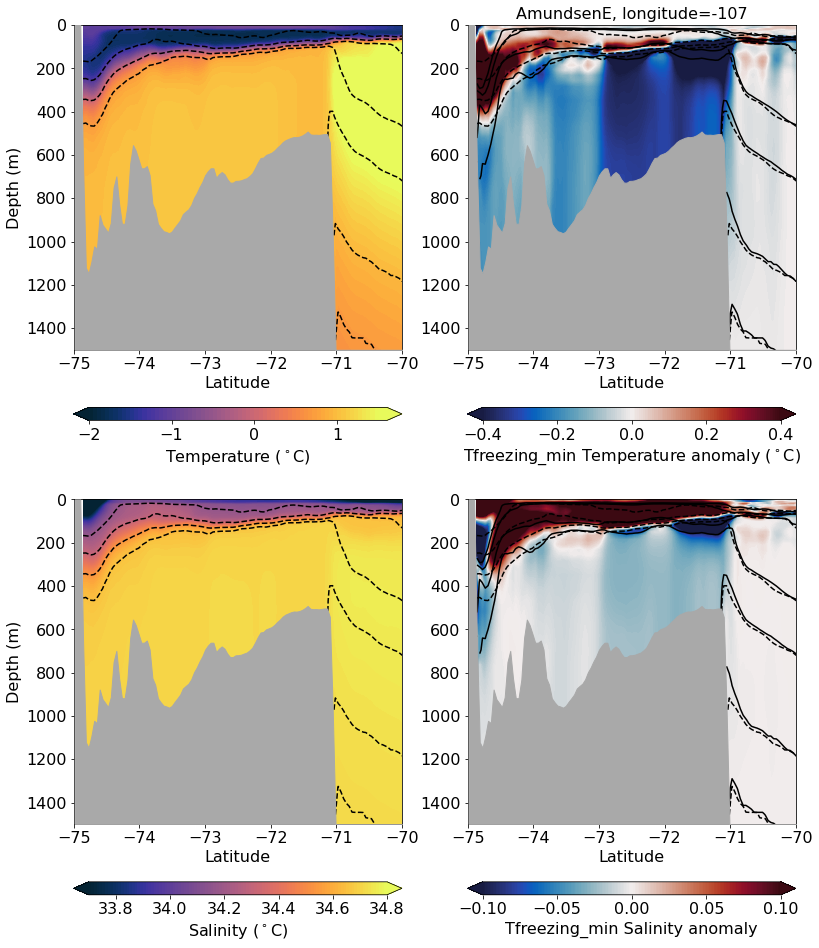

In [33]:
plot_transects('AmundsenE')

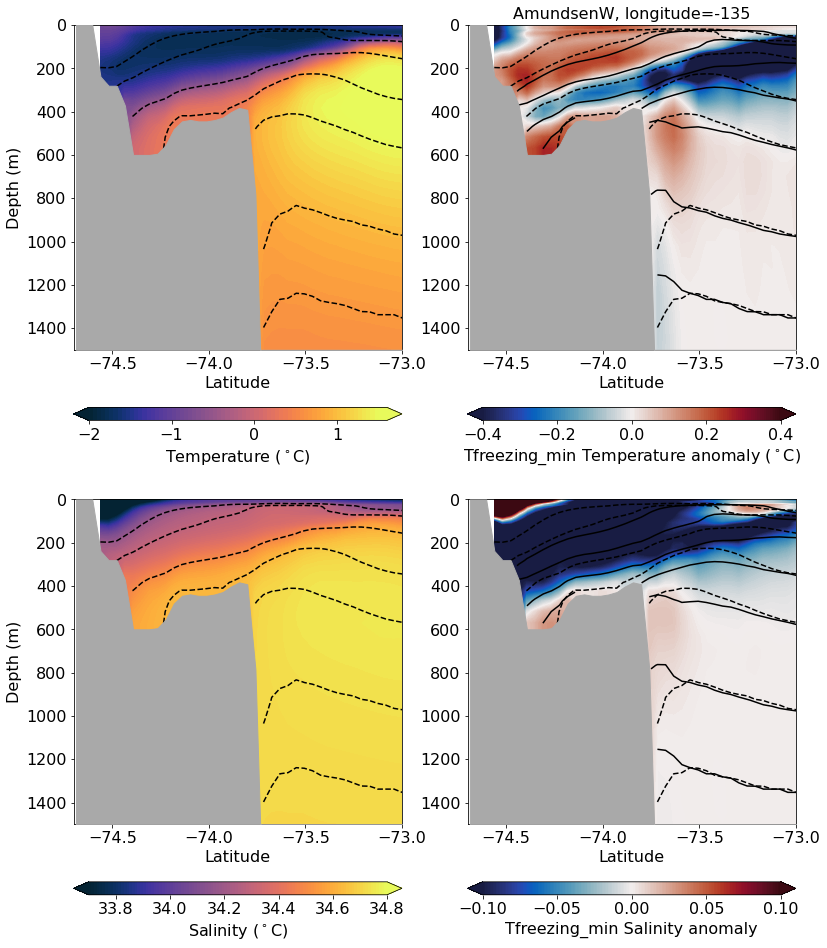

In [34]:
plot_transects('AmundsenW')

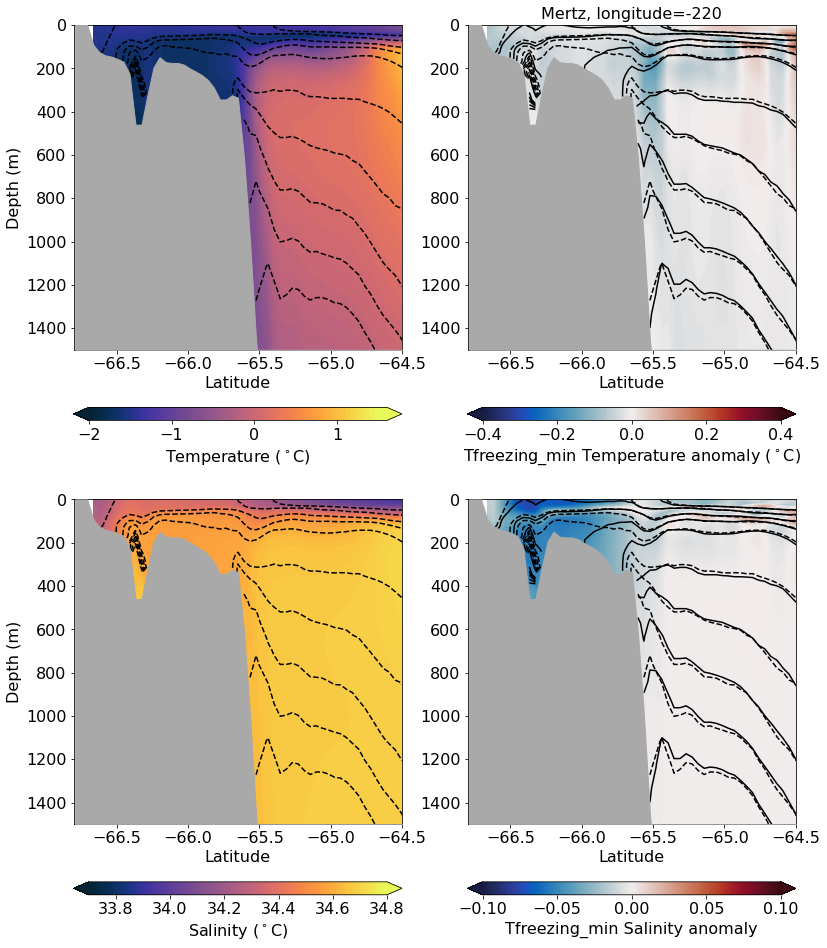

In [35]:
plot_transects('Mertz')

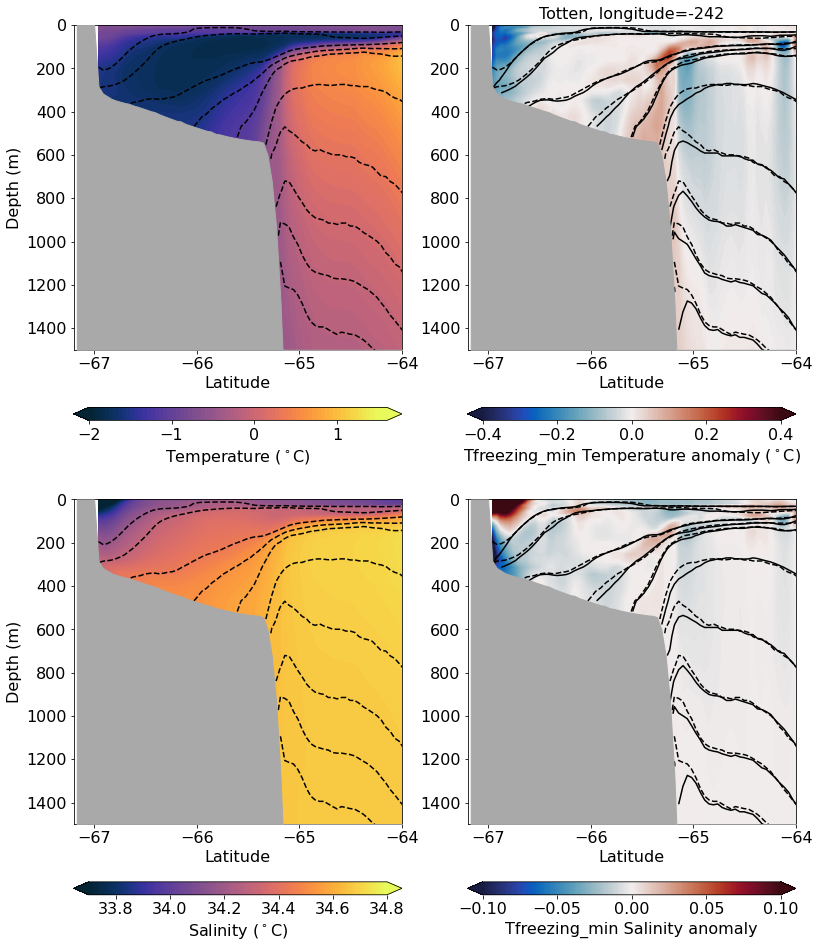

In [36]:
plot_transects('Totten')

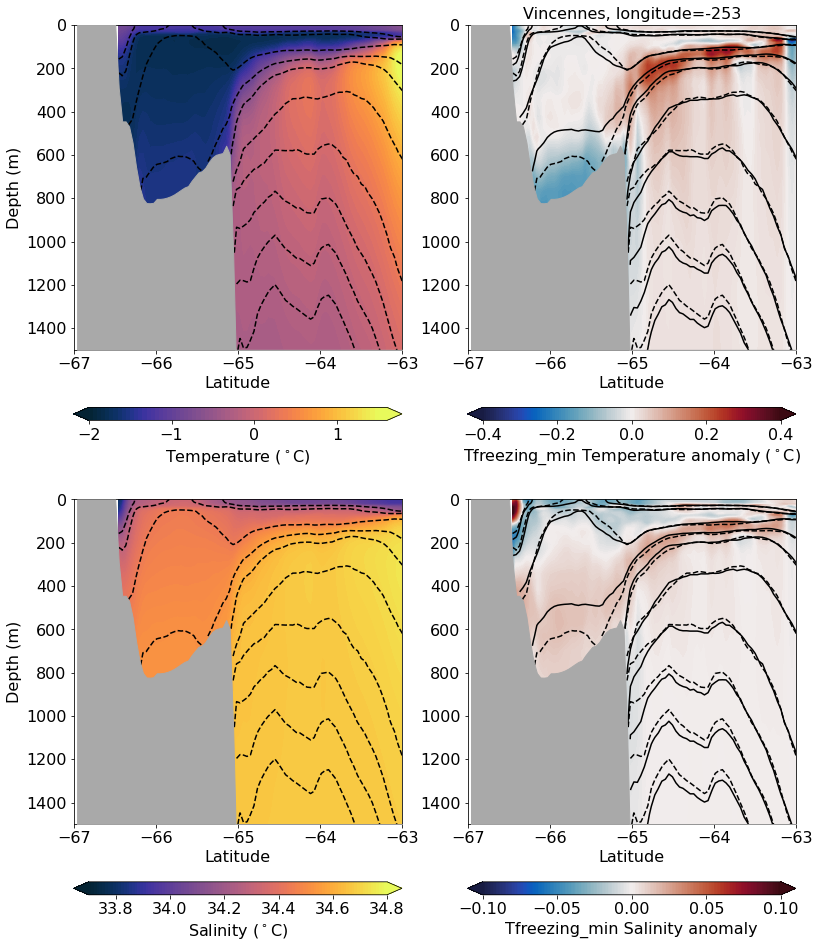

In [37]:
plot_transects('Vincennes')

2022-08-11 06:31:13,761 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2022-08-11 06:31:15,831 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2022-08-11 06:31:18,720 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2022-08-11 06:31:21,993 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


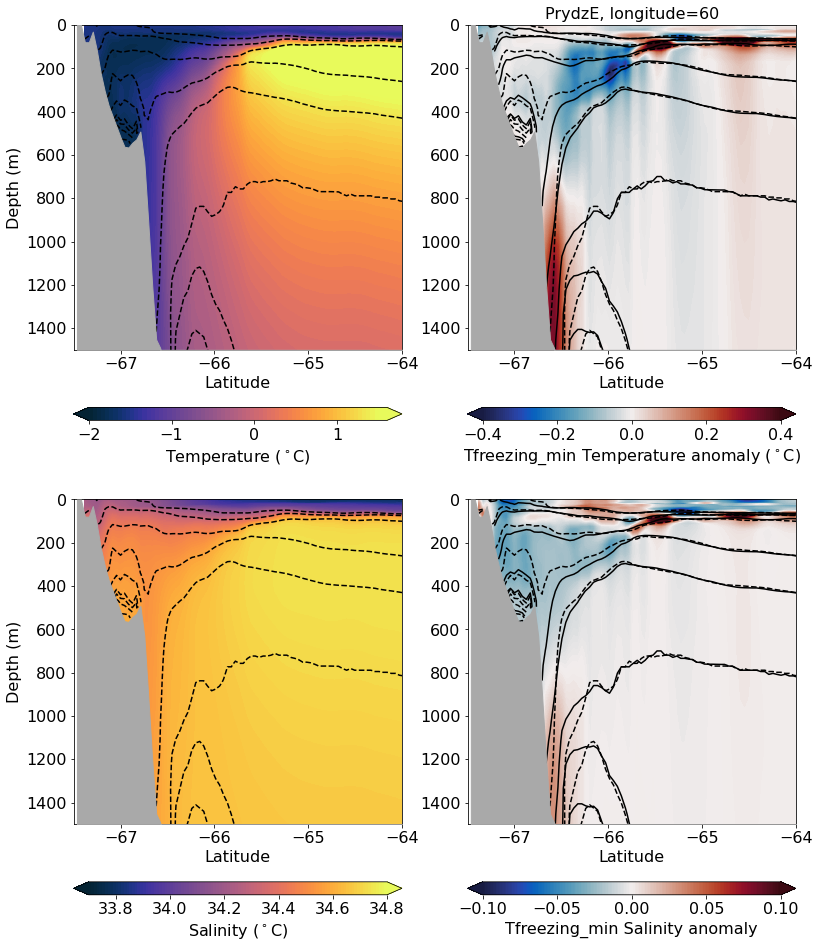

In [38]:
plot_transects('PrydzE')

2022-08-11 06:31:27,149 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-08-11 06:31:28,164 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-08-11 06:31:32,018 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-08-11 06:31:35,212 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


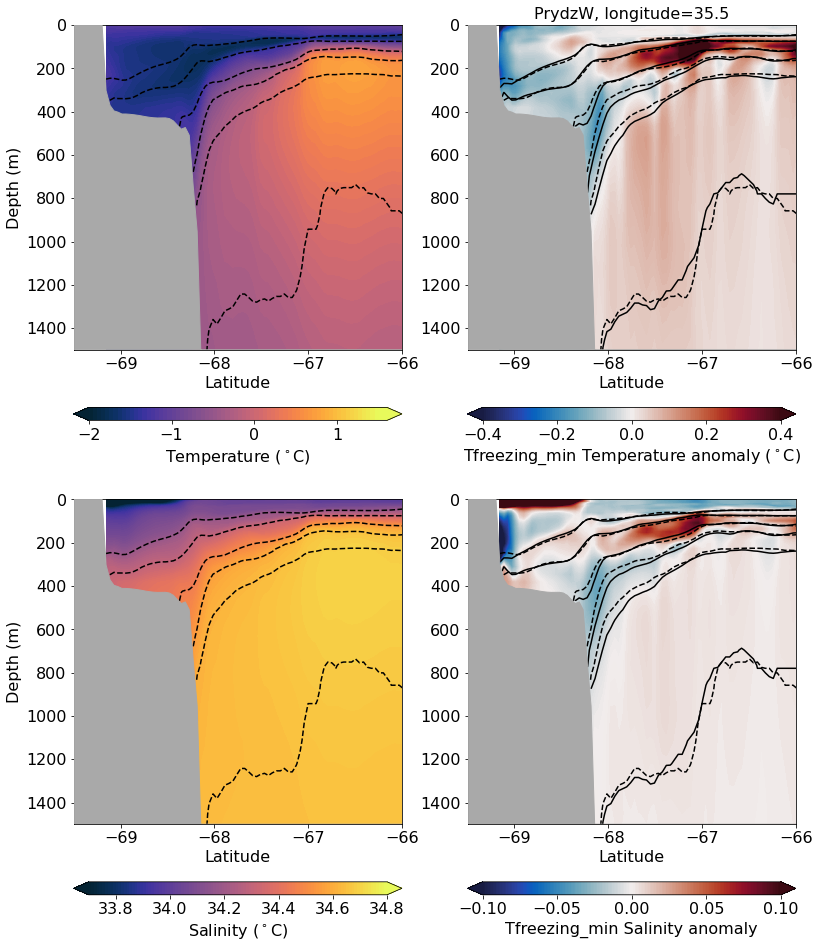

In [39]:
plot_transects('PrydzW')